<a href="https://colab.research.google.com/github/kimjc95/computational-chemistry/blob/main/Ligand_Docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Docking을 Colab에서
2023-12-19 by Joo-Chan Kim at MSBL, KAIST

준비물 :

1. 리간드의 MOL 파일 (결합차수, 전하가 제대로 입력되어 있어야 함)

2. 단백질의 PDB 파일 (heterogen이 있거나 일부 원자가 빠져있어도 상관 X)

3. Google 계정, 인터넷 연결

In [ ]:
#@title Conda 설치
#@markdown 런타임이 종료되었다가 다시 연결되는데, 당황하지 마시고 이어서 실행하시면 됩니다.

# Colab에서 Conda 실행하기 위해 준비
!pip install -q condacolab
import condacolab
condacolab.install()
!rm -rf /usr/local/conda-meta/pinned

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


In [ ]:
#@title Dependencies 설치
#@markdown (1분 가량 소요)
#@markdown 이틈에 Receptor PDB 파일과 Ligand MOL 파일을 업로드 해주세요.

!git clone -q --depth=1 https://github.com/QVina/qvina.git
!chmod -R 755 /content/qvina
!mamba install -q -c conda-forge numpy scipy rdkit parmed biopython pdbfixer nglview mdanalysis
!pip3 install -q meeko pdb4amber

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Lipinski import RotatableBondSmarts
from rdkit.Chem.rdDetermineBonds import DetermineConnectivity
from IPython.display import Image
from pdbfixer import PDBFixer
from openmm import *
from openmm.app import *
from openmm.unit import *
from Bio.PDB import *
from prolif.plotting.network import LigNetwork
import os
import locale
import warnings
import parmed
import numpy as np
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from google.colab import output
output.enable_custom_widget_manager()
output.clear()

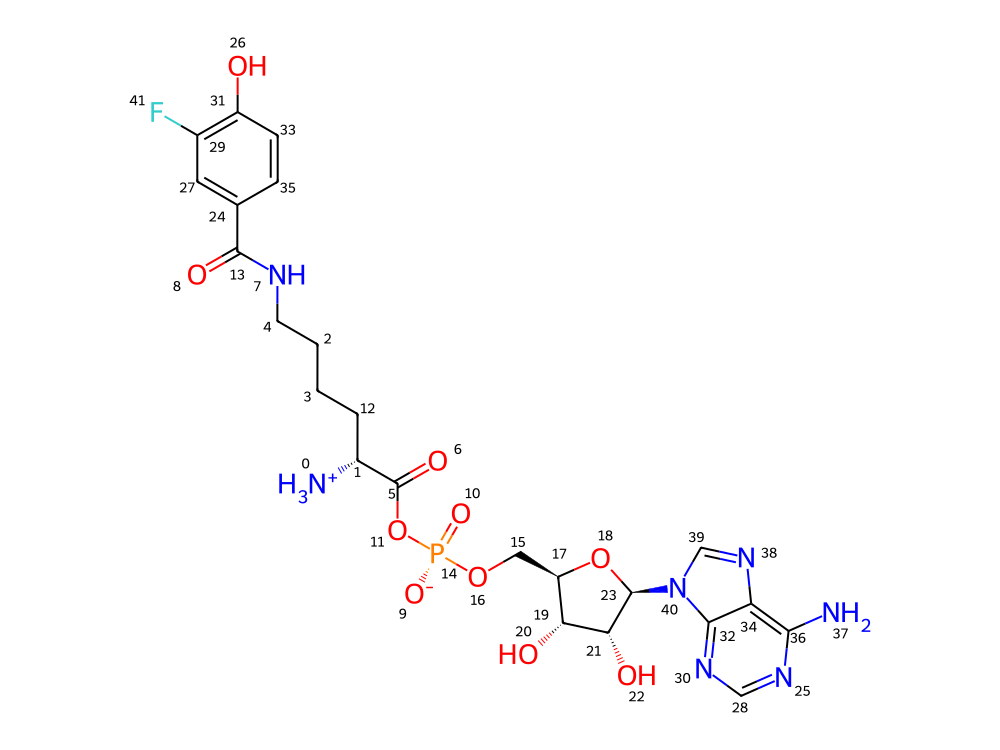

In [ ]:
#@title **1. Ligand.pdbqt 준비**
#@markdown 수소가 없는 ligand MOL 파일의 이름을 입력해주세요.

#@markdown 구조를 확인하고 전하나 결합차수가 맞는지 확인해주세요.

#@markdown 그림에 나온 원자번호는 0부터 셉니다.

ligandFile = "FhbK.mol" #@param {type:"string"}

IPythonConsole.molSize = 1000,750
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.addBondIndices = False

mol = Chem.MolFromMolFile(ligandFile)
Chem.SanitizeMol(mol)
Chem.rdCoordGen.AddCoords(mol)
mol

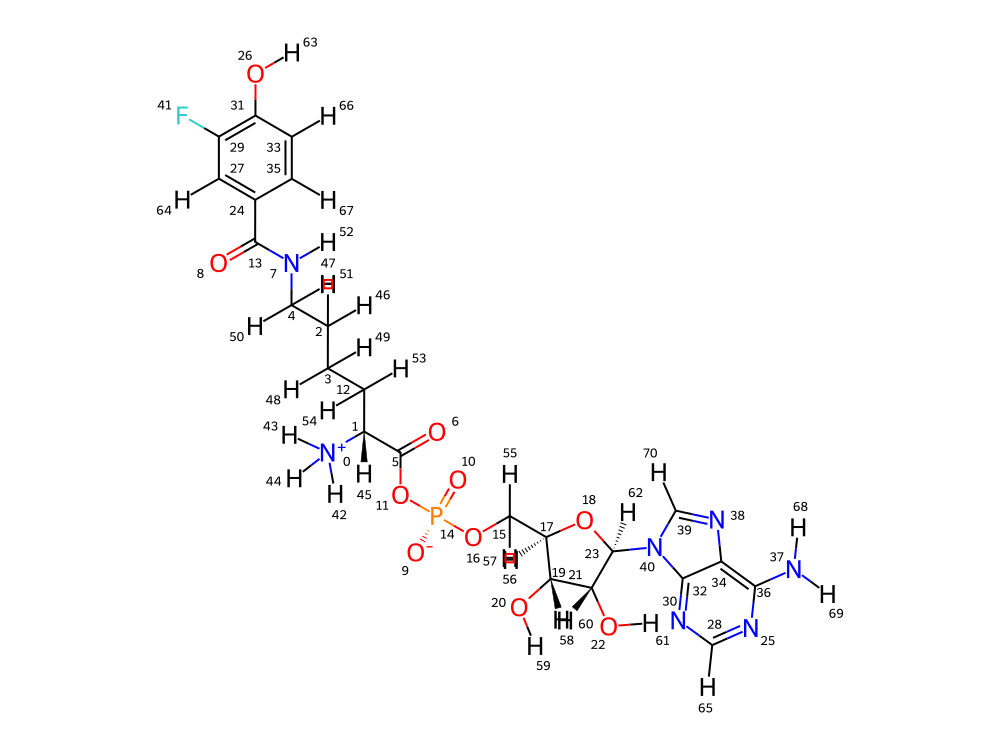

In [ ]:
# @markdown 수소를 자동으로 더합니다.
mol_wH = Chem.rdmolops.AddHs(mol, explicitOnly=False, addCoords=True)
mol_wH

Number of rotatable bonds : 17
Number of amide bonds : 1


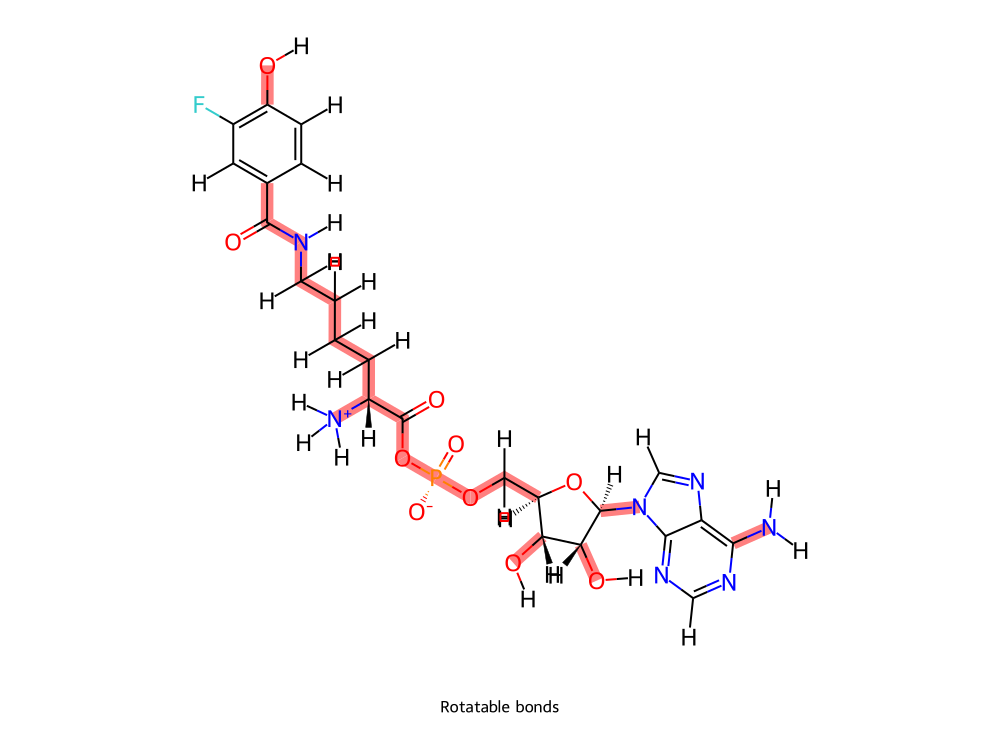

In [ ]:
#@markdown 회전 가능한 공유결합을 붉은색으로 표시해줍니다.

d = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(1000, 750)

n_rot_bonds = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol_wH)
n_amide_bonds = Chem.rdMolDescriptors.CalcNumAmideBonds(mol_wH)
print("Number of rotatable bonds : "+str(n_rot_bonds))
print("Number of amide bonds : "+str(n_amide_bonds))

rot_atom_pairs = mol_wH.GetSubstructMatches(RotatableBondSmarts)
rot_bonds = list(set([mol_wH.GetBondBetweenAtoms(*ap).GetIdx() for ap in rot_atom_pairs]))

Chem.Draw.rdMolDraw2D.PrepareAndDrawMolecule(d, mol_wH, legend='Rotatable bonds', highlightBonds=rot_bonds)
d.WriteDrawingText("rotatable_bond_highlight.png")
Image("rotatable_bond_highlight.png")

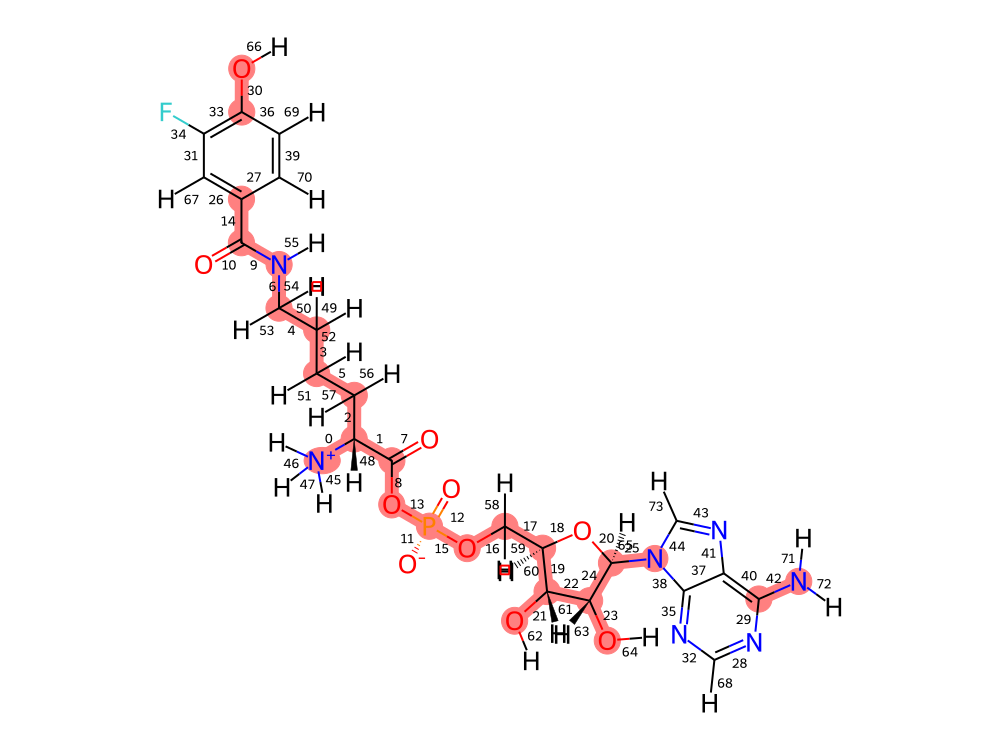

In [ ]:
# @markdown 이제 원자가 아닌 결합에 번호를 붙여 표시해드립니다.

# @markdown 잘 보고 회전을 고정하고 싶은 결합 번호를 0 1 2 이런 식으로 입력해주세요.
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addBondIndices = True

fix_bonds = "9 14 42" #@param {type:"string"}
fix_bonds_idx = [int(s) for s in fix_bonds.split(' ')]
mol_wH

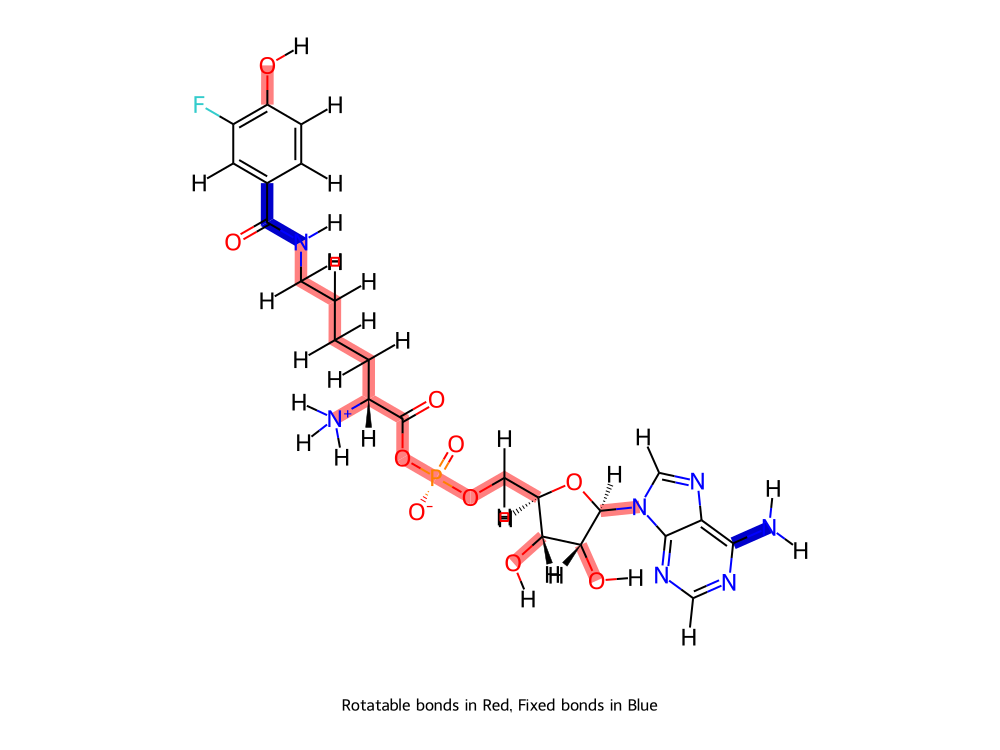

In [ ]:
# @markdown 고정된 결합은 파랑색으로 표시하였습니다.

# @markdown 수정이 필요하시면 다시 위의 셀을 실행해주세요.

bond_colors = {}

for bond in Chem.rdchem.Mol.GetBonds(mol_wH):
    if bond.GetIdx() in fix_bonds_idx:
        bond_colors[bond.GetIdx()] = (0.0,0.0,0.8)
    elif bond in rot_bonds:
        bond_colors[bond.GetIdx()] = (0.8,0.0,0.0)

d2 = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(1000, 750)

Chem.Draw.rdMolDraw2D.PrepareAndDrawMolecule(d2, mol_wH, legend='Rotatable bonds in Red, Fixed bonds in Blue',
                                            highlightBonds=rot_bonds, highlightBondColors=bond_colors)

d2.WriteDrawingText("fixed_bond_highlight.png")
Image("fixed_bond_highlight.png")

In [ ]:
# @markdown 리간드 3차원 구조를 최적화할 ForceField를 선택해주세요.

FFtype = "UFF" #@param ['MMFF','UFF']

# @markdown 최적화된 구조는 ligand.sdf에 저장됩니다.

Chem.AllChem.EmbedMolecule(mol_wH)

if FFtype == 'UFF':
    Chem.AllChem.UFFOptimizeMolecule(mol_wH, maxIters=200)
else:
    Chem.AllChem.MMFFOptimizeMolecule(mol_wH, maxIters=200)
mblock = Chem.MolToMolBlock(mol_wH)
writer = Chem.SDWriter('ligand.sdf')
writer.write(mol_wH, confId=0)


view = nv.NGLWidget()
view.add_structure(nv.RdkitStructure(mol_wH))
view._set_size('1000px','750px')
view

NGLWidget()

In [ ]:
# @markdown prepare_ligand.py로 ligand.pdbqt 파일을 준비합니다.

SMILES = Chem.rdmolfiles.MolToSmiles(mol_wH)
rotatable = ""

for i in fix_bonds_idx:
    bond = mol_wH.GetBondWithIdx(i)
    a1 = bond.GetBeginAtom().GetIdx()+1
    a2 = bond.GetEndAtom().GetIdx()+1
    rotatable = rotatable + ' -r "'+SMILES+'" -b '+str(a1)+" "+str(a2)

if os.system('mk_prepare_ligand.py -i ligand.sdf -o ligand.pdbqt'+rotatable) == 0:
    print("ligand.pdbqt successfully generated.")

ligand.pdbqt successfully generated.


In [ ]:
# @title **2. Receptor.pdbqt 준비**
# @markdown Receptor PDB 파일명을 입력해주세요.

receptorFile = "MaPylRS.pdb" # @param {type:"string"}

view2 = nv.NGLWidget()
view2._set_size('1000px','750px')
view2.add_structure(nv.FileStructure(receptorFile))
view2


NGLWidget()

In [ ]:
# @markdown 수소를 더해줄 기준 pH를 설정하세요.
pH = 7.0 #@param {type:"slider", min:0.0, max:14.0, step:0.1}
# @markdown 고쳐진 PDB 파일은 receptor-final.pdb로 저장됩니다.

fixer = PDBFixer(filename=receptorFile)
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH)

forcefield = ForceField("amber14-all.xml")
system = forcefield.createSystem(fixer.topology, CutoffNonPeriodic, 1.0*nanometers, HBonds, None, True)
integrator = LangevinMiddleIntegrator(300,1,1)
simulation = Simulation(fixer.topology, system, integrator)
simulation.context.setPositions(fixer.positions)
simulation.minimizeEnergy()

with open('receptor-fixed.pdb', 'w') as f:
    positions = simulation.context.getState(getPositions=True).getPositions()
    PDBFile.writeFile(fixer.topology, positions, f)

os.system('pdb4amber -i receptor-fixed.pdb -o receptorwithH.pdb -p --most-populous')

warnings.filterwarnings(action='ignore')

parser = PDBParser()
s = parser.get_structure('receptor', 'receptorwithH.pdb')

for chain in s.get_chains():
    for atom in chain[1].get_atoms():
        if atom.get_name() == 'H':
            setattr(atom, "id", 'H1')
            setattr(atom, "name", 'H1')
            setattr(atom, "fullname", ' H1  ')
            print(atom.id)

com = s.center_of_mass()
s.transform(np.array([[1,0,0],[0,1,0],[0,0,1]]), tran=-1*com)


io = PDBIO()
io.set_structure(s)
io.save("receptor-final.pdb")

view3 = nv.NGLWidget()
view3._set_size('1000px','750px')
view3.add_structure(nv.FileStructure("receptor-final.pdb"))
view3.add_surface(lowResolution= True, smooth=1,opacity=0.4)

view3

H1


NGLWidget()

In [ ]:
# @markdown Grid Box center 좌표 (in Angstrom)를 입력하세요.

# @markdown 혹은 위 위젯에서 원자를 클릭하시고 아래 좌표 입력칸을 비워두세요.

center_x = "-5" #@param {type:"string"}
center_y = "-10" #@param {type:"string"}
center_z = "9" #@param {type:"string"}

if center_x == "" or center_y == "" or center_z == "":
    if view3.picked == {}:
        raise ValueError("좌표가 입력되지 않았습니다.")
    else:
        center_x = view3.picked["atom1"]["x"]
        center_y = view3.picked["atom1"]["y"]
        center_z = view3.picked["atom1"]["z"]
else:
    center_x = float(center_x)
    center_y = float(center_y)
    center_z = float(center_z)

print(f"Box Center is {center_x:.3f}, {center_y:.3f}, {center_z:.3f}")


Box Center is -5.000, -10.000, 9.000


In [ ]:
# @markdown Grid Box의 길이, 폭, 높이를 입력하세요.
len_x = "30" #@param {type:"string"}
len_y = "45" #@param {type:"string"}
len_z = "35" #@param {type:"string"}

# @markdown 이 셀을 실행 후 아래 위젯에서 박스 크기와 위치를 확인하세요.

# @markdown center 좌표나 box 크기를 바꾼 후 이 셀을 다시 실행해 확인하세요.

# @markdown 빨강이 x축, 초록이 y축, 파랑이 z축입니다.
show_sidechain = False # @param {type:"boolean"}

len_x = float(len_x)
len_y = float(len_y)
len_z = float(len_z)

corner1 = [center_x+len_x/2, center_y+len_y/2, center_z+len_z/2]
corner2 = [center_x-len_x/2, center_y+len_y/2, center_z+len_z/2]
corner3 = [center_x-len_x/2, center_y-len_y/2, center_z+len_z/2]
corner4 = [center_x+len_x/2, center_y-len_y/2, center_z+len_z/2]
corner5 = [center_x+len_x/2, center_y+len_y/2, center_z-len_z/2]
corner6 = [center_x-len_x/2, center_y+len_y/2, center_z-len_z/2]
corner7 = [center_x-len_x/2, center_y-len_y/2, center_z-len_z/2]
corner8 = [center_x+len_x/2, center_y-len_y/2, center_z-len_z/2]

view3 = nv.NGLWidget()
view3._set_size('1000px','750px')
view3.add_structure(nv.FileStructure("receptor-final.pdb"))
view3.add_surface(lowResolution= True, smooth=1,opacity=0.4)

view3.shape.add_cylinder(corner1, corner2, [1,1,1], [0.1])
view3.shape.add_cylinder(corner2, corner3, [1,1,1], [0.1])
view3.shape.add_cylinder(corner3, corner4, [1,1,1], [0.1])
view3.shape.add_cylinder(corner4, corner1, [1,1,1], [0.1])
view3.shape.add_cylinder(corner1, corner5, [1,1,1], [0.1])
view3.shape.add_cylinder(corner2, corner6, [1,1,1], [0.1])
view3.shape.add_cylinder(corner3, corner7, [0,0,1], [0.2])
view3.shape.add_cylinder(corner4, corner8, [1,1,1], [0.1])
view3.shape.add_cylinder(corner5, corner6, [1,1,1], [0.1])
view3.shape.add_cylinder(corner6, corner7, [0,1,0], [0.2])
view3.shape.add_cylinder(corner7, corner8, [1,0,0], [0.2])
view3.shape.add_cylinder(corner8, corner5, [1,1,1], [0.1])

if show_sidechain:
    view3.add_licorice("sidechain")
view3

NGLWidget()

In [ ]:
# @markdown 지정하고 싶은 Flexible residue들을 쉼표로 구분하여 입력하세요.

# @markdown "Chain ID : Residue name : Residue number" 식으로 공백없이 써주세요.
flexible_residues = "A:GLU:218,A:SER:221,A:ARG:248" # @param {type:"string"}

# @markdown 지정된 flexible residue를 확인하세요.

fr = flexible_residues.split(',')

flex_res = ""
selection = ""

if fr != [""]:
    flexFlag = True
else:
    flexFlag = False

if flexFlag:
    for i, res in enumerate(fr):
        flex_res = flex_res + " -f "+res
        resinfo = res.split(':')
        selection = selection + "(:"+resinfo[0]+" and "+resinfo[2]+")"
        if i != (len(fr)-1):
            selection = selection + " or "

view3 = nv.NGLWidget()
view3._set_size('1000px','750px')
view3.add_structure(nv.FileStructure("receptor-final.pdb"))
view3.add_surface(lowResolution= True, smooth=1,opacity=0.4)
view3.shape.add_cylinder(corner1, corner2, [1,1,1], [0.1])
view3.shape.add_cylinder(corner2, corner3, [1,1,1], [0.1])
view3.shape.add_cylinder(corner3, corner4, [1,1,1], [0.1])
view3.shape.add_cylinder(corner4, corner1, [1,1,1], [0.1])
view3.shape.add_cylinder(corner1, corner5, [1,1,1], [0.1])
view3.shape.add_cylinder(corner2, corner6, [1,1,1], [0.1])
view3.shape.add_cylinder(corner3, corner7, [0,0,1], [0.2])
view3.shape.add_cylinder(corner4, corner8, [1,1,1], [0.1])
view3.shape.add_cylinder(corner5, corner6, [1,1,1], [0.1])
view3.shape.add_cylinder(corner6, corner7, [0,1,0], [0.2])
view3.shape.add_cylinder(corner7, corner8, [1,0,0], [0.2])
view3.shape.add_cylinder(corner8, corner5, [1,1,1], [0.1])

if flexFlag:
    view3.add_licorice(selection=selection, color='red')
    view3.add_surface(selection=selection, color='red',
                      lowresolution=False, smooth=1,opacity=0.8)

view3

NGLWidget()

In [ ]:
# @markdown prepare_receptor.py로 receptor.pdbqt를 준비합니다.

if os.system('mk_prepare_receptor.py --pdb receptor-final.pdb -o receptor.pdbqt --box_size '+str(len_x)+' '+str(len_y)+' '+str(len_z)+' --box_center '+str(center_x)+' '+str(center_y)+' '+str(center_z)+flex_res) == 0:
    print('receptor.pdbqt successfully generated.')

receptor.pdbqt successfully generated.


In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

# @title **3. QuickVina2를 이용한 도킹**
output = "ligand_out.pdbqt"
# @markdown Exhaustiveness 값을 설정하세요. 클 수록 오래 걸립니다.
exhaustiveness = 32 #@param {type:"slider", min:8, max:512, step:8}
# @markdown 도킹 로그는 docking_log.txt에, 결과는 ligand_out.pdbqt에 저장됩니다.

if flexFlag:
    rigid = "receptor = receptor_rigid.pdbqt\n"
    flex_rec = "flex = receptor_flex.pdbqt\n"
else:
    rigid = "receptor.pdbqt\n"
    flex_rec = ""

with open('config', 'w') as f:
    f.write(rigid)
    f.write("ligand = ligand.pdbqt\n")
    f.write("center_x = "+str(center_x)+'\n')
    f.write("center_y = "+str(center_x)+'\n')
    f.write("center_z = "+str(center_x)+'\n')
    f.write("size_x = "+str(len_x)+'\n')
    f.write("size_y = "+str(len_y)+'\n')
    f.write("size_z = "+str(len_z)+'\n')
    f.write("out = "+output+'\n')
    f.write("log = docking_log.txt\n")
    f.write("exhaustiveness = "+str(exhaustiveness)+'\n')
    f.write(flex_rec)

!/content/qvina/bin/qvina2.1 --config config

############################################################################
# If you used Quick Vina 2 in your work, please cite:                      #
#                                                                          #
# Amr Alhossary, Stephanus Daniel Handoko, Yuguang Mu, and Chee-Keong Kwoh,#
# Fast, Accurate, and Reliable Molecular Docking with QuickVina 2,         #
# Bioinformatics (2015), doi: 10.1093/bioinformatics/btv082                #
#                                                                          #
# You are also encouraged to cite Quick Vina 1:                            #
# Stephanus Daniel Handoko, Xuchang Ouyang, Chinh Tran To Su, Chee Keong   #
# Kwoh, Yew Soon Ong,                                                      #
# QuickVina: Accelerating AutoDock Vina Using Gradient-Based Heuristics for#
# Global Optimization,                                                     #
# IEEE/ACM Transactions on Computational Biology and Bioinformatics,vol.9, #

In [ ]:
# @title **4. 결과 분석**
# @markdown ligand_out.pdbqt 파일을 읽어들입니다.

pdb = PDBFile('receptor-final.pdb')
modeller = Modeller(pdb.topology, pdb.positions)

Hstodelete = []

for bond in modeller.topology.bonds():
    A = bond[0]
    B = bond[1]

    if A.element == element.hydrogen and B.element == element.carbon:
        Hstodelete.append(A)
    elif A.element == element.carbon and B.element == element.hydrogen:
        Hstodelete.append(B)

Hstodelete = list(set(Hstodelete))

modeller.delete(Hstodelete)

def typeConverter(universe):

    type2element = {'H':'H','C':'C','A':'C','N':'N','P':'P','S':'S','Br':'Br','BR':'Br','I':'I','F':'F','Cl':'Cl','CL':'Cl',
                    'NA':'N','OA':'O','SA':'S','OS':'O','NS':'N','HD':'H','HS':'H','Mg':'Mg','Ca':'Ca','Fe':'Fe','Zn':'Zn',
                    'Mn': 'Mn','MG':'Mg','CA':'Ca','FE':'Fe','ZN':'Zn','MN':'Mn','G':'C','J':'C','Q':'C','GA':'C'}

    elements = []
    for i in range(len(universe.atoms)):
        elements.append(type2element[universe.atoms.types[i]])
    #universe.add_TopologyAttr('types', elements)
    universe.add_TopologyAttr('elements', elements)

    return universe


ligs = typeConverter(mda.Universe("ligand_out.pdbqt"))

size = len(ligs.atoms)/9


l = []
for i in range(9):
    b_i = int(i*size)
    e_i = int((i+1)*size-1)
    l.append(ligs.select_atoms("index "+str(b_i)+':'+str(e_i), sorted=False).convert_to("PARMED"))

In [ ]:
# @markdown 보고 싶은 pose를 선택하세요.
flexFlag=True
if flexFlag:
    r = typeConverter(mda.Universe("receptor_rigid.pdbqt")).atoms.convert_to("PARMED")
else:
    r = parmed.read_PDB("receptor-final.pdb")

pose = "1" # @param [1,2,3,4,5,6,7,8,9]

c = r+l[int(pose)-1]

view4 = nv.NGLWidget()
view4._set_size('1000px', '750px')
view4.add_structure(nv.ParmEdTrajectory(c), defaultRepresentation=False)
view4.add_cartoon(selection="protein")
view4.add_surface(selection="protein", smooth=1, opacity=0.5)
view4.add_ball_and_stick(selection="not protein", aspectRatio=2.5)
view4

NGLWidget()

In [ ]:
# @markdown 위에서 정한 docked pose를 파일로 저장합니다.

u = mda.Universe(c)

flex_res = []

if flexFlag:
    fr = flexible_residues.split(',')
    for res in fr:
        res_info = res.split(':')
        flex_res.append(u.select_atoms("protein and resname "+res_info[1]+" and resnum "+res_info[2]))

for i in range(len(flex_res)):
    res = u.atoms.split('residue')[-i-1]
    a = res.select_atoms("name CA")
    dists = []
    for res2 in flex_res:
        resids_A, resids_B, dist = distances.dist(a,res2.select_atoms("name C"))
        dists.append(list(dist)[0])

    nearest = flex_res[dists.index(min(dists))][0]
    res.residues.resnames = nearest.resname
    res.residues.resnums = nearest.resnum

lig_w_pose = u.select_atoms("not protein").convert_to("RDKIT")
lmol = Chem.rdmolops.AddHs(lig_w_pose, explicitOnly=False, addCoords=True, addResidueInfo=True)

prot = u.select_atoms("protein").convert_to("PARMED")
modeller2 = Modeller(modeller.topology, prot.positions)

modeller2.addHydrogens(forcefield, pH)
system = forcefield.createSystem(modeller2.topology, CutoffNonPeriodic, 1.0*nanometers, None, True, True)
prot_parmed = parmed.openmm.load_topology(modeller2.topology, system, modeller2.positions)
u = mda.Universe(prot_parmed + parmed.load_rdkit(lmol))
lig = u.select_atoms("not protein")
prot = u.select_atoms("protein")

pdb = mda.coordinates.PDB.PDBWriter(filename="docked_pose_"+str(pose)+".pdb", bonds="all", n_atoms=u.atoms.n_atoms)
pdb.write_all_timesteps(u)